In [1]:
# !pip install -e .

In [2]:
from deeplens.extractor import ExtractSingleSample
from deeplens.intervene import InterveneFeatures, ReinjectSingleSample
from deeplens.utils.analysis import plot_topk_distribution, get_top_k_tokens

In [3]:
def pipeline(
        text,
        model: str = "gpt2",
        layer: int = 3,
        sae_model: str = r"saved_models\gpt2L3-untied\run_20251229_102023\best_model.pt",
        sae_config: str = r"C:\code\deeplens\demo\config.yaml",
        feature: int = -1,
        alpha: float = 5.0,
        tok_position: int = -1,
        generate: bool = False,
        max_new_tokens: int = 25,
        temperature: float = 1.0
    ):
    extractor = ExtractSingleSample(
        model=model,
        layer=layer,
        max_length=1024,
        device="auto"
    )
    intervene = InterveneFeatures(
        sae_model=sae_model,
        sae_config=sae_config,
        device="auto"
    )
    reinject = ReinjectSingleSample(
        hf_model=model,
        device="auto"
    )
    
    acts = extractor.get_mlp_acts(text)
    features = intervene.get_alive_features(acts, token_position=-1)
    
    # Both original and modified are now SAE-decoded
    original, original_decoded, modified_decoded = intervene.intervene_feature(
        activations=acts,
        feature=features[feature].item(),
        alpha=alpha,
        token_positions=tok_position
    )

    raw_output = reinject.reinject_and_generate(
        text=text,
        modified_activations=original,  # raw activations
        layer=layer,
        generate=generate,
        max_new_tokens=max_new_tokens,
        temperature=temperature
    )
    
    # Get outputs for both
    original_output = reinject.reinject_and_generate(
        text=text,
        modified_activations=original_decoded,
        layer=layer,
        generate=generate,
        max_new_tokens=max_new_tokens,
        temperature=temperature
    )
    
    modified_output = reinject.reinject_and_generate(
        text=text,
        modified_activations=modified_decoded,
        layer=layer,
        generate=generate,
        max_new_tokens=max_new_tokens,
        temperature=temperature
    )
    
    return raw_output, original_output, modified_output

In [4]:
original, original_output, modified_output = pipeline(
    text="He was born in",
    model="gpt2",
    layer=3,
    sae_model=r"saved_models\gpt2L3-untied\run_20251229_102023\best_model.pt",
    sae_config=r"C:\code\deeplens\demo\config.yaml",
    feature=-1,
    alpha=10.0,
    tok_position=-1,
    generate=False,
    temperature=1.0
)

Running on device: cuda
Running on device: cuda
Running on device: cuda


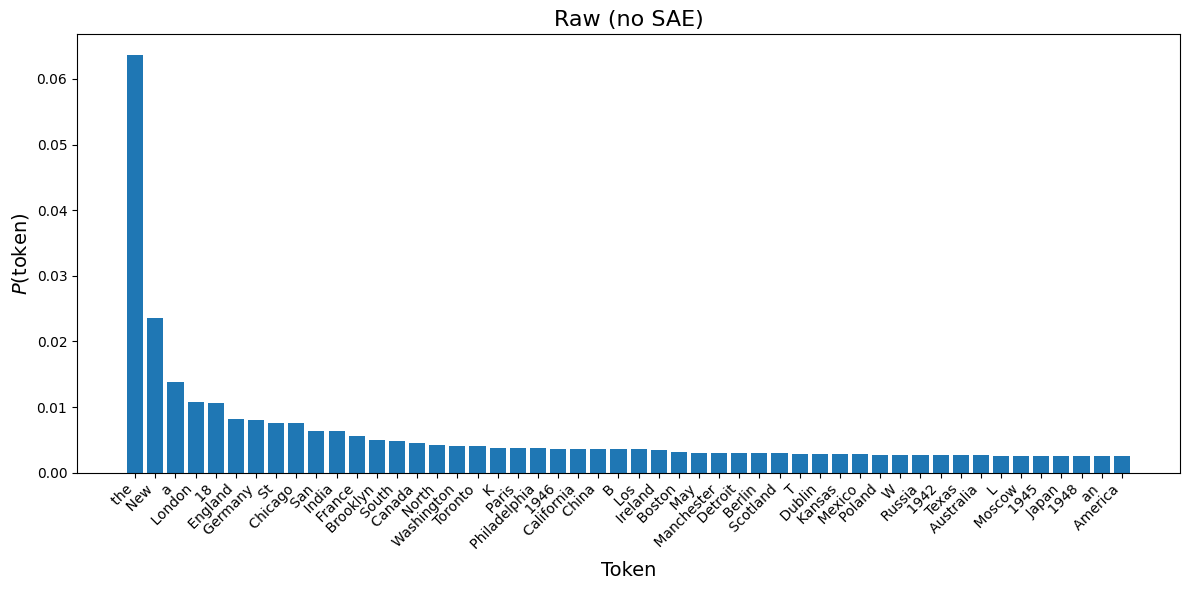

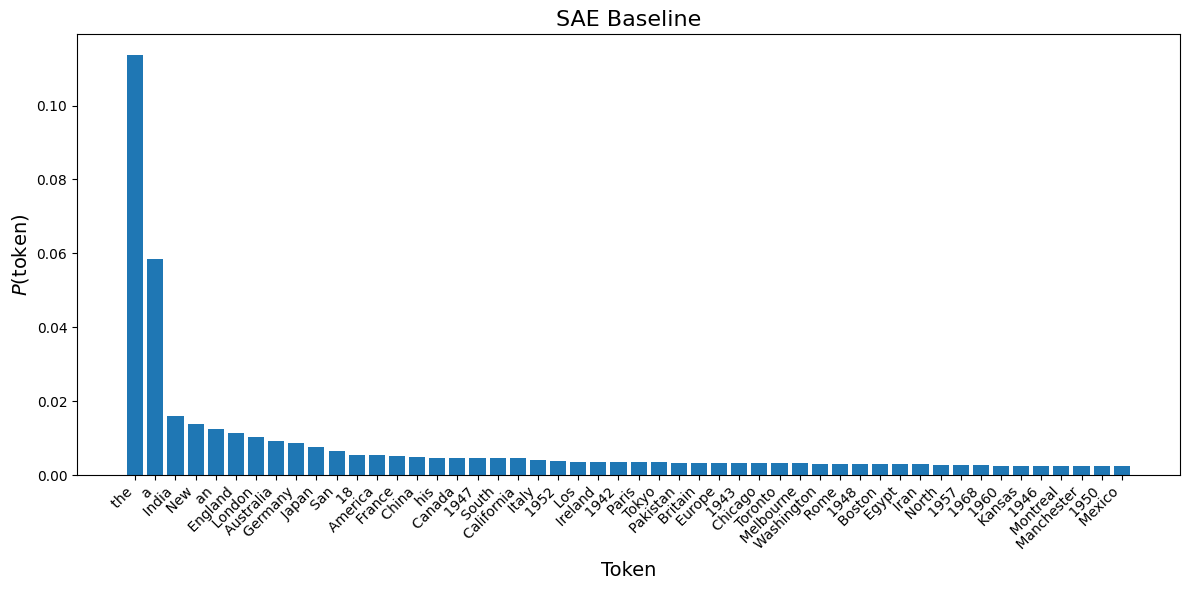

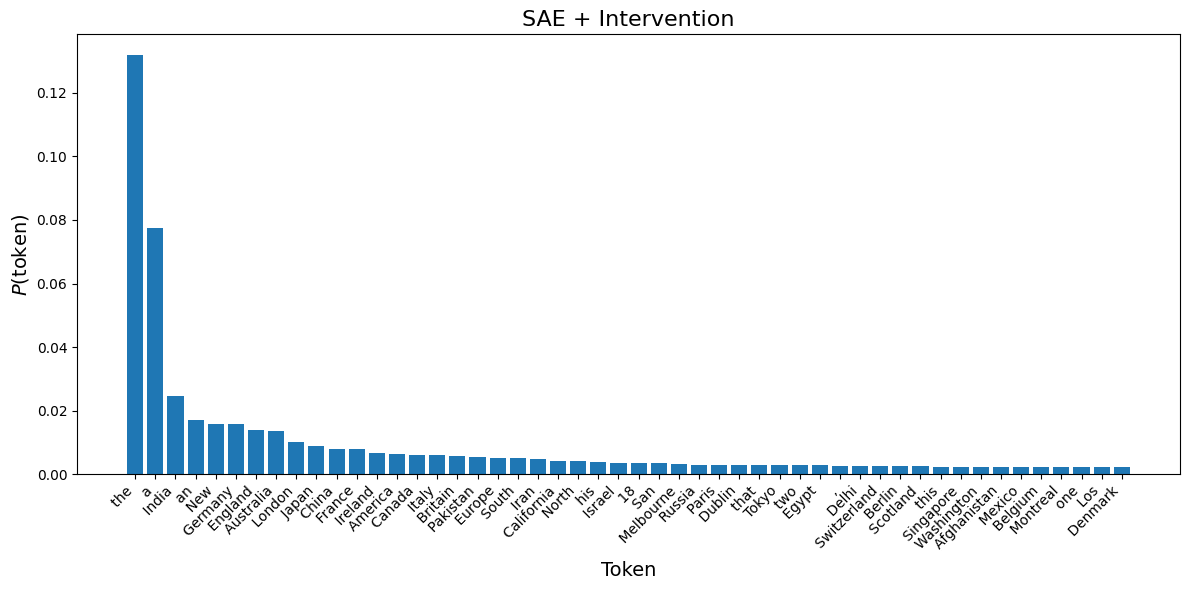

In [ ]:
plot_topk_distribution(
    original, 
    use_softmax=True, 
    k=50, 
    position=-1, 
    title="Raw (no SAE)"
)

plot_topk_distribution(
    original_output, 
    use_softmax=True, 
    k=50, 
    position=-1, 
    title="SAE Baseline"
)

plot_topk_distribution(
    modified_output, 
    use_softmax=True, 
    k=50, 
    position=-1, 
    title="SAE + Intervention"
)